This notebook shows how load a normalizing flow into a Creator object, and draw samples of galaxy redshifts, magnitudes, and conditional pdf's.

In [1]:
from creator import Creator
from normalizingFlow import NormalizingFlow
from rqNeuralSplineFlow import RQNeuralSplineFlow

In [2]:
%config InlineBackend.figure_format = 'retina'

First, load the generator, which in this case will be the normalizing flow created in `redshift_flow_example.ipynb`

In [3]:
# load the generator
flow = NormalizingFlow(RQNeuralSplineFlow, file='demo_flow.pkl')

In [4]:
# instantiate the creator
creator = Creator(flow)

Now let's draw 10k samples from the flow

In [5]:
%%time 
# draw the samples
samples = creator.sample(5000, include_pdf=False, seed=0)

CPU times: user 9.06 s, sys: 388 ms, total: 9.45 s
Wall time: 8.35 s


In [6]:
# print the first few
samples.head()

,redshift,u,g,r,i,z,y,uerr,gerr,rerr,ierr,zerr,yerr
0,0.922039,27.839732,26.749966,24.643532,23.521185,22.643559,22.317938,0.181339,0.019694,0.004077,0.003172,0.002875,0.004795
1,1.839557,33.311560,29.241939,28.580303,27.362249,25.995525,25.370708,2.154105,0.291858,0.088330,0.060313,0.031308,0.050262
2,0.245878,24.235136,23.419050,22.881184,22.725330,22.574855,22.576463,0.009313,0.002165,0.001565,0.002061,0.002768,0.005696
3,0.384001,26.764275,26.523852,25.988920,25.994652,25.710801,25.964868,0.063014,0.016276,0.009997,0.017047,0.024950,0.081401
4,1.174314,27.155508,26.874787,26.322675,25.775474,25.145163,24.733469,0.092022,0.021747,0.012721,0.014453,0.015262,0.028767


In [7]:
# get size of the samples
nMB = samples.memory_usage(index=True).sum()/1e6
print(f'size of samples in memory is {nMB:.3f} MB')

size of samples in memory is 0.380 MB


Let's draw the same sample, but this time get the conditional pdf's as well.

In [8]:
%%time
# draw the samples and include pdf's
samples_wPDF = creator.sample(5000, include_pdf=True, seed=0)

CPU times: user 11min 30s, sys: 11min 22s, total: 22min 52s
Wall time: 3min 54s


/global/u1/j/jfc20/RAIL/rail/creation/normalizingFlow.py:184: RuntimeWarning: invalid value encountered in true_divide
  pdfs = pdfs / (pdfs * dz).sum(axis=1).reshape(-1,1)


A few samples have redshift < 0. Cut these out. Might want to make sure this doesn't occur in the future...

In [9]:
samples_wPDF = samples_wPDF[samples_wPDF['redshift'] > 0]

In [10]:
import numpy as np
samples_wPDF.attrs['pz_grid'] = np.arange(0, 2.02, 0.02)

In [11]:
# print the first few
samples_wPDF.head()

,redshift,u,g,r,i,z,y,uerr,gerr,rerr,ierr,zerr,yerr,pz_pdf
0,0.922039,27.837062,26.760640,24.651609,23.524658,22.646598,22.307521,0.181339,0.019694,0.004077,0.003172,0.002875,0.004795,"[2.3630294e-11, 2.5911351e-11, 3.281167e-11, 2..."
1,1.839557,27.532653,29.595488,28.514095,27.514445,25.987778,25.379859,2.154105,0.291858,0.088330,0.060313,0.031308,0.050262,"[5.6353446e-17, 3.0710913e-17, 1.7667443e-17, ..."
2,0.245878,24.230412,23.418301,22.880505,22.725016,22.575982,22.573134,0.009313,0.002165,0.001565,0.002061,0.002768,0.005696,"[1.6329946e-05, 6.069869e-05, 0.00040405887, 0..."
3,0.384001,26.881358,26.490873,25.984773,25.996992,25.758759,25.900299,0.063014,0.016276,0.009997,0.017047,0.024950,0.081401,"[5.1011487e-08, 5.4977704e-08, 1.3471175e-07, ..."
4,1.174314,27.123137,26.886896,26.317130,25.762356,25.153947,24.706916,0.092022,0.021747,0.012721,0.014453,0.015262,0.028767,"[9.492737e-06, 1.0236413e-05, 1.0668453e-05, 1..."


In [12]:
# get size of the samples w pdf's
nMB = samples_wPDF.memory_usage(index=True).sum()/1e6
print(f'size of samples_wPDF in memory is {nMB:.3f} MB')

size of samples_wPDF in memory is 0.460 MB


Lets plot a few of the pdf's

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches

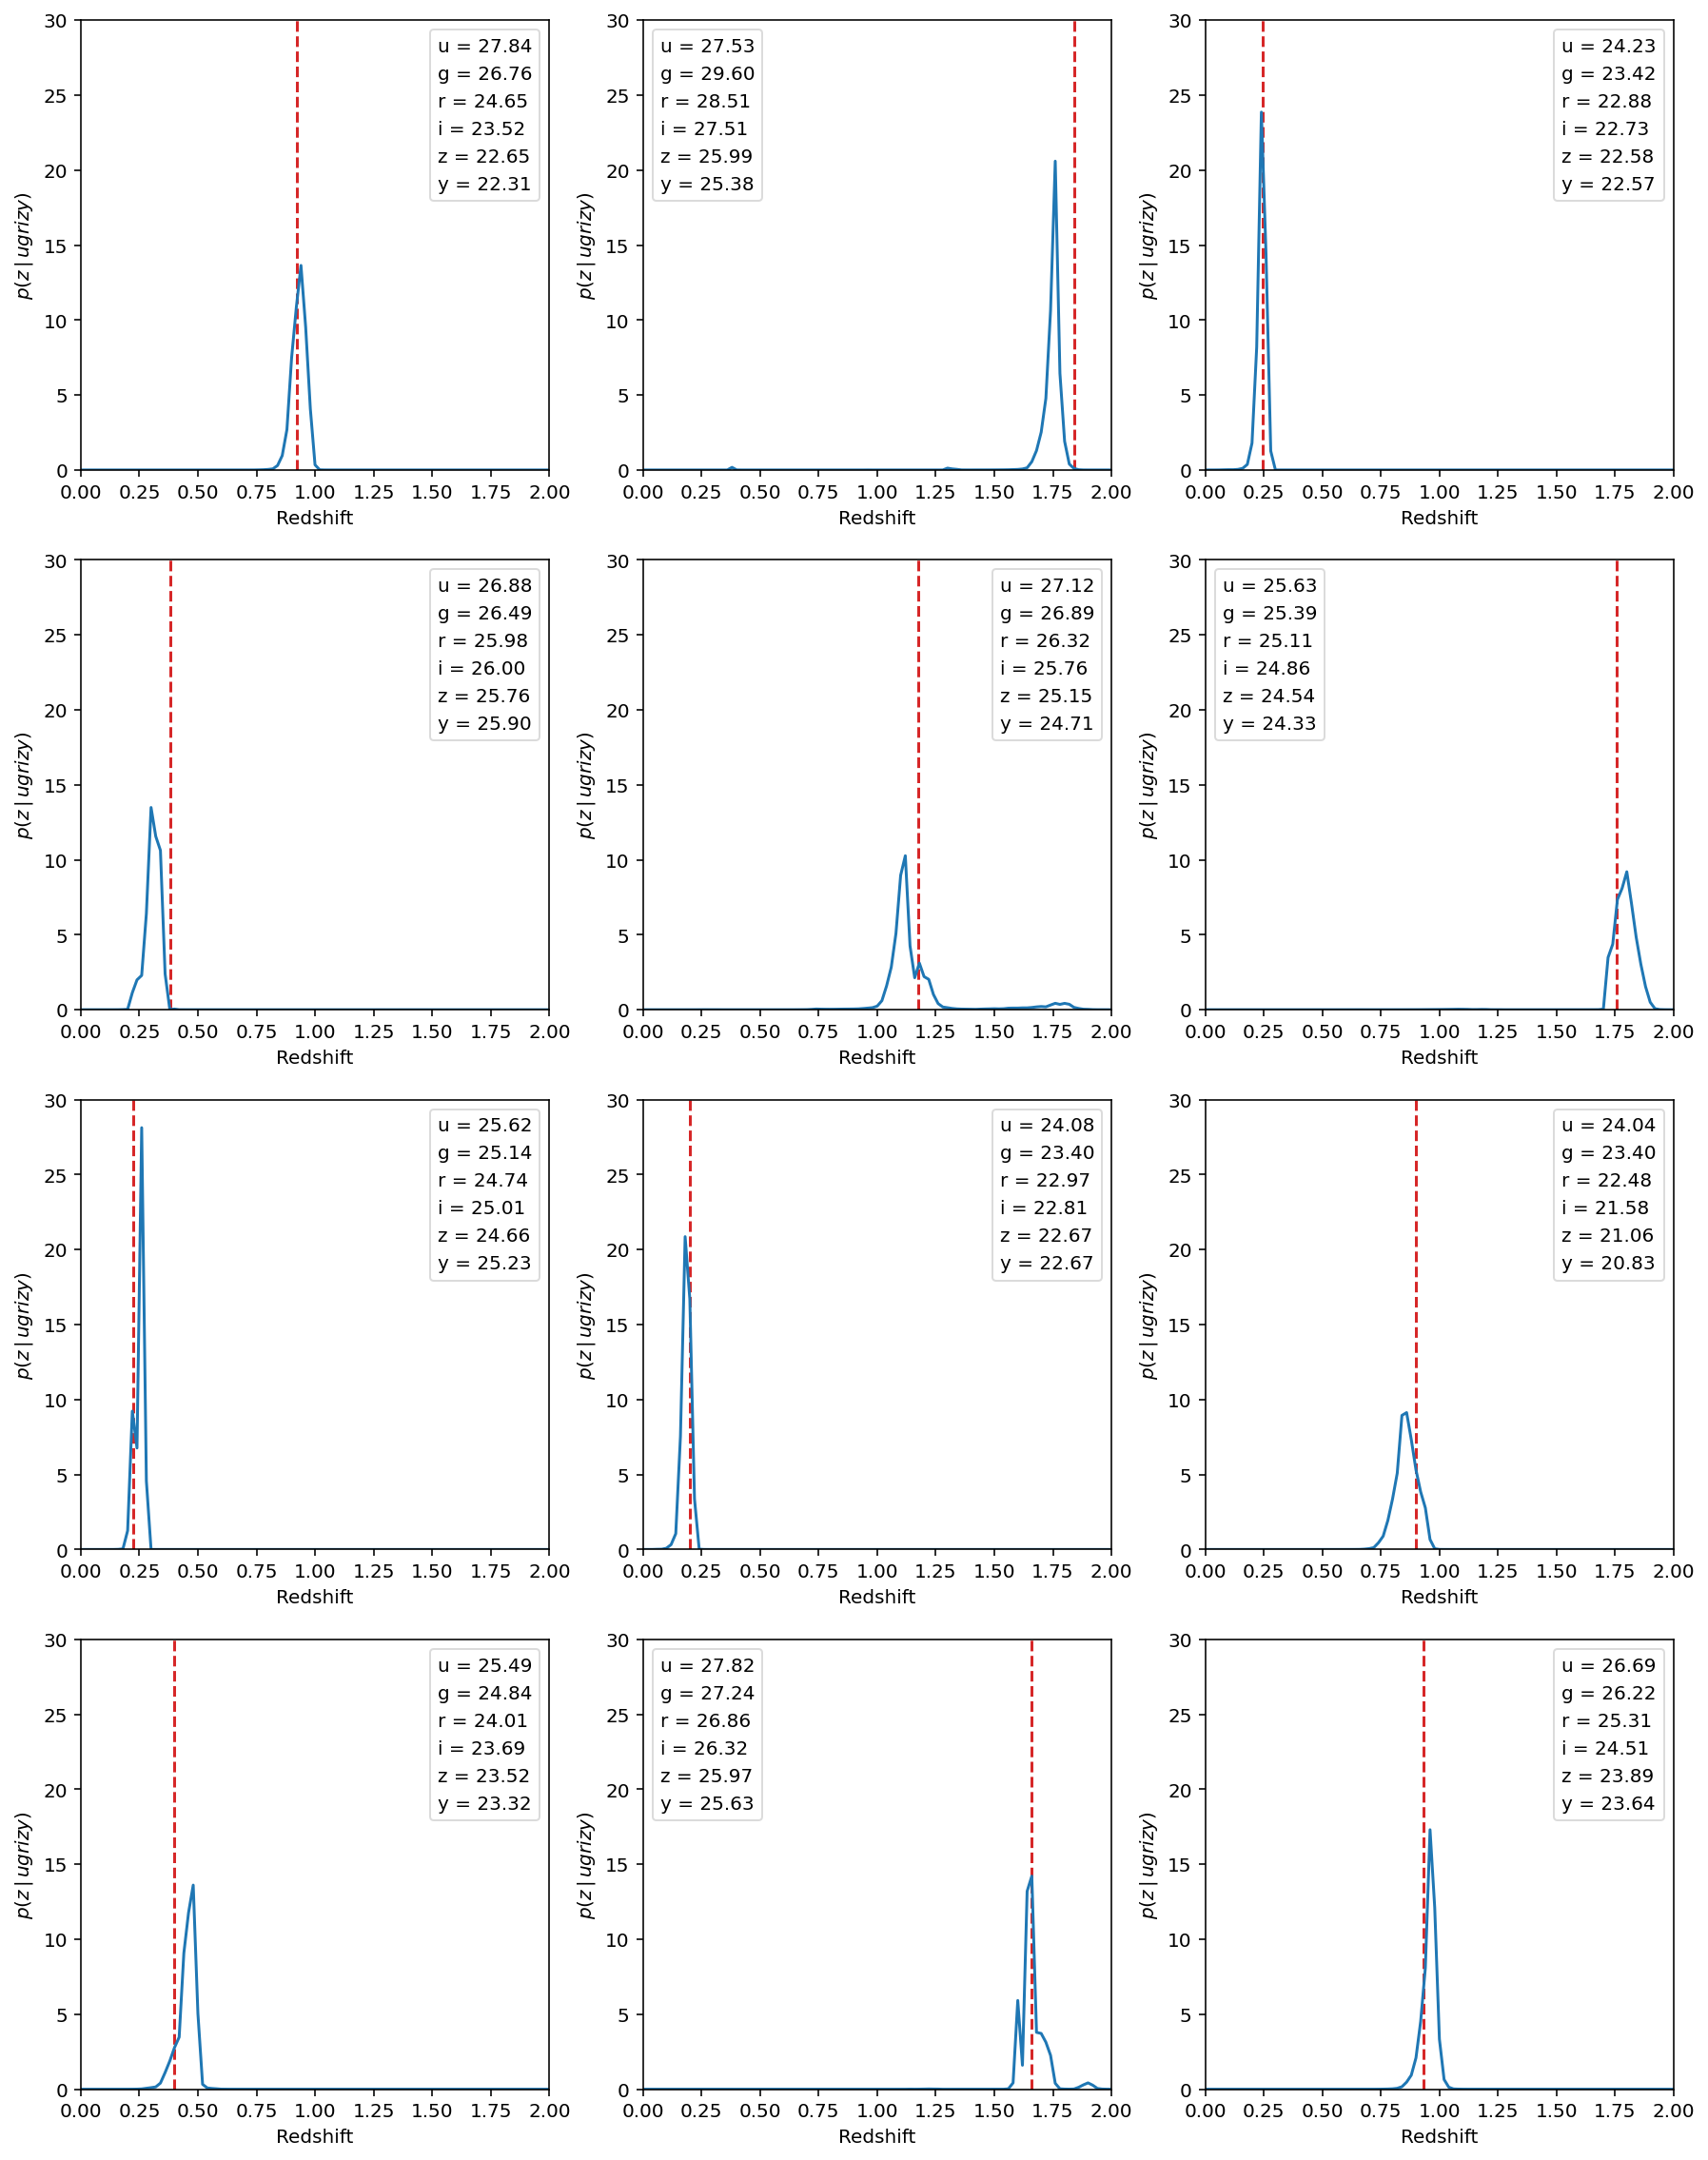

In [57]:
fig,axes = plt.subplots(4, 3, figsize=(15,20))

axes = axes.flatten()

for idx in range(len(axes)):
    
    zs = samples_wPDF.attrs['pz_grid']
    redshift,u,g,r,i,z,y,*_,pz = samples_wPDF.loc[idx]
    axes[idx].plot(zs, pz)
    
    axes[idx].axvline(redshift, c='C3', ls='--', zorder=0)
    
    # create legend with magnitudes
    handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", lw=0, alpha=0)] * 6
    labels = []
    band_labels = ['u', 'g', 'r', 'i', 'z', 'y']
    for band,mag in zip(band_labels, [u,g,r,i,z,y]):
        labels.append(f'{band} = {mag:.2f}')
    axes[idx].legend(handles, labels, loc='best', 
              fancybox=True, framealpha=0.7, 
              handlelength=0, handletextpad=0)
    
    axes[idx].set_xlim(0,2)
    axes[idx].set_ylim(0,30)
    axes[idx].set_xlabel("Redshift")
    axes[idx].set_ylabel("$p(z \,|\, ugrizy)$")
    
#fig.savefig('plots/conditional_prob_12.pdf')

In [60]:
maxes = []
for pz in samples_wPDF['pz_pdf']:
    maxes.append(samples_wPDF.attrs['pz_grid'][pz.argmax()])

(0.0, 2.25)

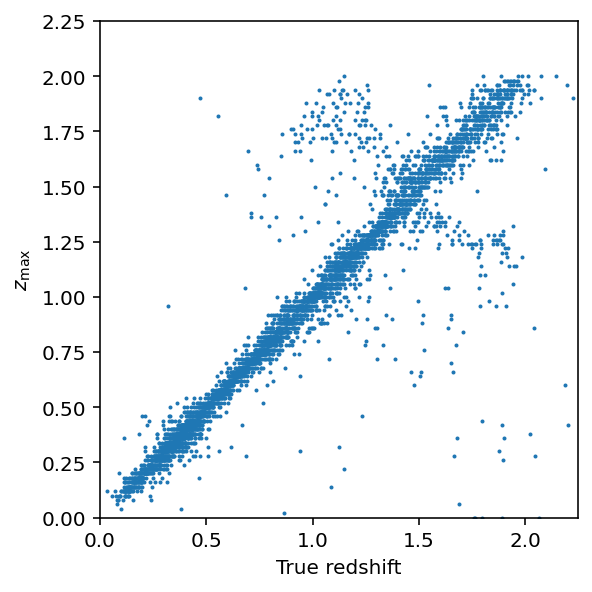

In [61]:
fig,ax = plt.subplots(figsize=(4,4), constrained_layout=True)
ax.scatter(samples_wPDF['redshift'], maxes, s=1)
ax.set_xlabel('True redshift')
ax.set_ylabel('$z_\mathrm{max}$')
ax.set_xlim(0,2.25)
ax.set_ylim(0,2.25)
#fig.savefig('plots/zmax_vs_redshift.pdf')